# Домашнее задание: Методы оптимизации в логистической регрессии

Реализация логистической регрессии с различными методами оптимизации (градиентный спуск, RMSProp, Nadam) для бинарной классификации на датасете Iris.

## 1. Импорт библиотек и загрузка данных

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Настройка воспроизводимости результатов
np.random.seed(42)

iris = load_iris()
X, y = iris.data, iris.target

# Оставляем только 2 класса: Iris Versicolor (1) и Iris Virginica (2)
mask = (y == 1) | (y == 2)
X_binary = X[mask]
y_binary = y[mask]

# Преобразуем метки в бинарные (0 и 1)
y_binary = (y_binary == 2).astype(int)

print(f"Размер данных: {X_binary.shape}")
print(f"Распределение классов: {np.bincount(y_binary)}")
print(f"Названия признаков: {iris.feature_names}")

Размер данных: (100, 4)
Распределение классов: [50 50]
Названия признаков: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


## 2. Подготовка данных

In [32]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Добавление столбца единиц для смещения
X_train_scaled = np.column_stack([np.ones(X_train_scaled.shape[0]), X_train_scaled])
X_test_scaled = np.column_stack([np.ones(X_test_scaled.shape[0]), X_test_scaled])

print(f"Обучающая выборка: {X_train_scaled.shape}")
print(f"Тестовая выборка: {X_test_scaled.shape}")

Обучающая выборка: (80, 5)
Тестовая выборка: (20, 5)


## 3. Реализация логистической регрессии

In [33]:
class LogisticRegression:
    """
    Класс для реализации логистической регрессии с различными методами оптимизации.
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.weights = None
        self.cost_history = []
        
    def sigmoid(self, z):
        """Сигмоидная функция активации"""
        z = np.clip(z, -500, 500)  # Предотвращение переполнения
        return 1 / (1 + np.exp(-z))
    
    def compute_cost(self, X, y):
        """Вычисление функции стоимости (логистическая потеря)"""
        m = len(y)
        predictions = self.sigmoid(X @ self.weights)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)  # Предотвращение log(0)
        
        cost = -1/m * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return cost
    
    def compute_gradient(self, X, y):
        """Вычисление градиента функции стоимости"""
        m = len(y)
        predictions = self.sigmoid(X @ self.weights)
        gradient = 1/m * X.T @ (predictions - y)
        return gradient
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        return self.sigmoid(X @ self.weights)
    
    def predict(self, X, threshold=0.5):
        """Бинарное предсказание"""
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def fit_gradient_descent(self, X, y):
        """Обучение с помощью градиентного спуска"""
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)
        self.cost_history = []
        
        for i in range(self.max_iterations):
            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)
            
            gradient = self.compute_gradient(X, y)
            self.weights -= self.learning_rate * gradient
            
            # Проверка сходимости
            if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tolerance:
                print(f"Градиентный спуск сошелся за {i+1} итераций")
                break
        
        return self
    
    def fit_rmsprop(self, X, y, beta=0.9, epsilon=1e-8):
        """Обучение с помощью RMSProp"""
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)
        self.cost_history = []
        
        # Инициализация накопленных квадратов градиентов
        E_g2 = np.zeros(n_features)
        
        for i in range(self.max_iterations):
            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)
            
            gradient = self.compute_gradient(X, y)
            
            # Обновление накопленных квадратов градиентов
            E_g2 = beta * E_g2 + (1 - beta) * gradient**2
            
            # Обновление весов
            self.weights -= self.learning_rate * gradient / (np.sqrt(E_g2) + epsilon)
            
            # Проверка сходимости
            if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tolerance:
                print(f"RMSProp сошелся за {i+1} итераций")
                break
        
        return self
    
    def fit_nadam(self, X, y, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """Обучение с помощью Nadam (Nesterov-accelerated Adaptive Moment Estimation)"""
        n_features = X.shape[1]
        self.weights = np.zeros(n_features)
        self.cost_history = []
        
        # Инициализация моментов
        m = np.zeros(n_features)  # Первый момент
        v = np.zeros(n_features)  # Второй момент
        
        for i in range(self.max_iterations):
            cost = self.compute_cost(X, y)
            self.cost_history.append(cost)
            
            gradient = self.compute_gradient(X, y)
            
            # Обновление смещенных моментов
            m = beta1 * m + (1 - beta1) * gradient
            v = beta2 * v + (1 - beta2) * gradient**2
            
            # Коррекция смещения
            m_hat = m / (1 - beta1**(i+1))
            v_hat = v / (1 - beta2**(i+1))
            
            # Nesterov acceleration
            m_nesterov = beta1 * m_hat + (1 - beta1) * gradient / (1 - beta1**(i+1))
            
            # Обновление весов
            self.weights -= self.learning_rate * m_nesterov / (np.sqrt(v_hat) + epsilon)
            
            # Проверка сходимости
            if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tolerance:
                print(f"Nadam сошелся за {i+1} итераций")
                break
        
        return self

## 4. Обучение моделей с различными методами оптимизации

=== Обучение с помощью градиентного спуска ===
Точность: 0.9000
Время обучения: 0.0191 сек



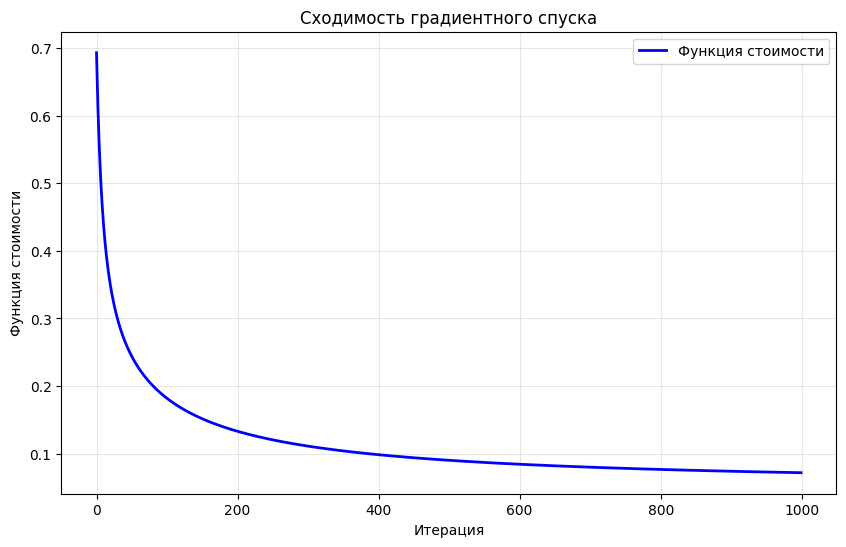

График сходимости создан! Количество итераций: 1000


In [34]:
# Список для хранения результатов
results = []

# 1. Градиентный спуск
print("=== Обучение с помощью градиентного спуска ===")
start_time = time.time()
lr_gd = LogisticRegression(learning_rate=0.1, max_iterations=1000)
lr_gd.fit_gradient_descent(X_train_scaled, y_train)
gd_time = time.time() - start_time

# Предсказания
y_pred_gd = lr_gd.predict(X_test_scaled)
accuracy_gd = accuracy_score(y_test, y_pred_gd)

print(f"Точность: {accuracy_gd:.4f}")
print(f"Время обучения: {gd_time:.4f} сек")
print()

# Визуализация сходимости градиентного спуска
plt.figure(figsize=(10, 6))
plt.plot(lr_gd.cost_history, 'b-', linewidth=2, label='Функция стоимости')
plt.xlabel('Итерация')
plt.ylabel('Функция стоимости')
plt.title('Сходимость градиентного спуска')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
print(f"График сходимости создан! Количество итераций: {len(lr_gd.cost_history)}")

# Сохранение результатов
results.append({
    'Метод': 'Градиентный спуск',
    'Точность': accuracy_gd,
    'Время (сек)': gd_time,
    'Итерации': len(lr_gd.cost_history)
})

In [35]:
# 2. RMSProp
print("=== Обучение с помощью RMSProp ===")
start_time = time.time()
lr_rmsprop = LogisticRegression(learning_rate=0.01, max_iterations=1000)
lr_rmsprop.fit_rmsprop(X_train_scaled, y_train)
rmsprop_time = time.time() - start_time

# Предсказания
y_pred_rmsprop = lr_rmsprop.predict(X_test_scaled)
accuracy_rmsprop = accuracy_score(y_test, y_pred_rmsprop)

print(f"Точность: {accuracy_rmsprop:.4f}")
print(f"Время обучения: {rmsprop_time:.4f} сек")
print()

# Сохранение результатов
results.append({
    'Метод': 'RMSProp',
    'Точность': accuracy_rmsprop,
    'Время (сек)': rmsprop_time,
    'Итерации': len(lr_rmsprop.cost_history)
})

=== Обучение с помощью RMSProp ===
RMSProp сошелся за 702 итераций
Точность: 0.9500
Время обучения: 0.0154 сек



In [36]:
# 3. Nadam
print("=== Обучение с помощью Nadam ===")
start_time = time.time()
lr_nadam = LogisticRegression(learning_rate=0.01, max_iterations=1000)
lr_nadam.fit_nadam(X_train_scaled, y_train)
nadam_time = time.time() - start_time

# Предсказания
y_pred_nadam = lr_nadam.predict(X_test_scaled)
accuracy_nadam = accuracy_score(y_test, y_pred_nadam)

print(f"Точность: {accuracy_nadam:.4f}")
print(f"Время обучения: {nadam_time:.4f} сек")
print()

# Сохранение результатов
results.append({
    'Метод': 'Nadam',
    'Точность': accuracy_nadam,
    'Время (сек)': nadam_time,
    'Итерации': len(lr_nadam.cost_history)
})

=== Обучение с помощью Nadam ===
Точность: 0.9500
Время обучения: 0.0254 сек



## 5. Сравнение результатов

In [37]:
# Создание таблицы результатов
results_df = pd.DataFrame(results)
print("=== Сравнение методов оптимизации ===")
print(results_df.to_string(index=False))

# Нахождение лучшего метода
best_method = results_df.loc[results_df['Точность'].idxmax()]
print(f"\nЛучший метод: {best_method['Метод']} с точностью {best_method['Точность']:.4f}")

=== Сравнение методов оптимизации ===
            Метод  Точность  Время (сек)  Итерации
Градиентный спуск      0.90     0.019122      1000
          RMSProp      0.95     0.015387       702
            Nadam      0.95     0.025420      1000

Лучший метод: RMSProp с точностью 0.9500


## 6. Визуализация сходимости

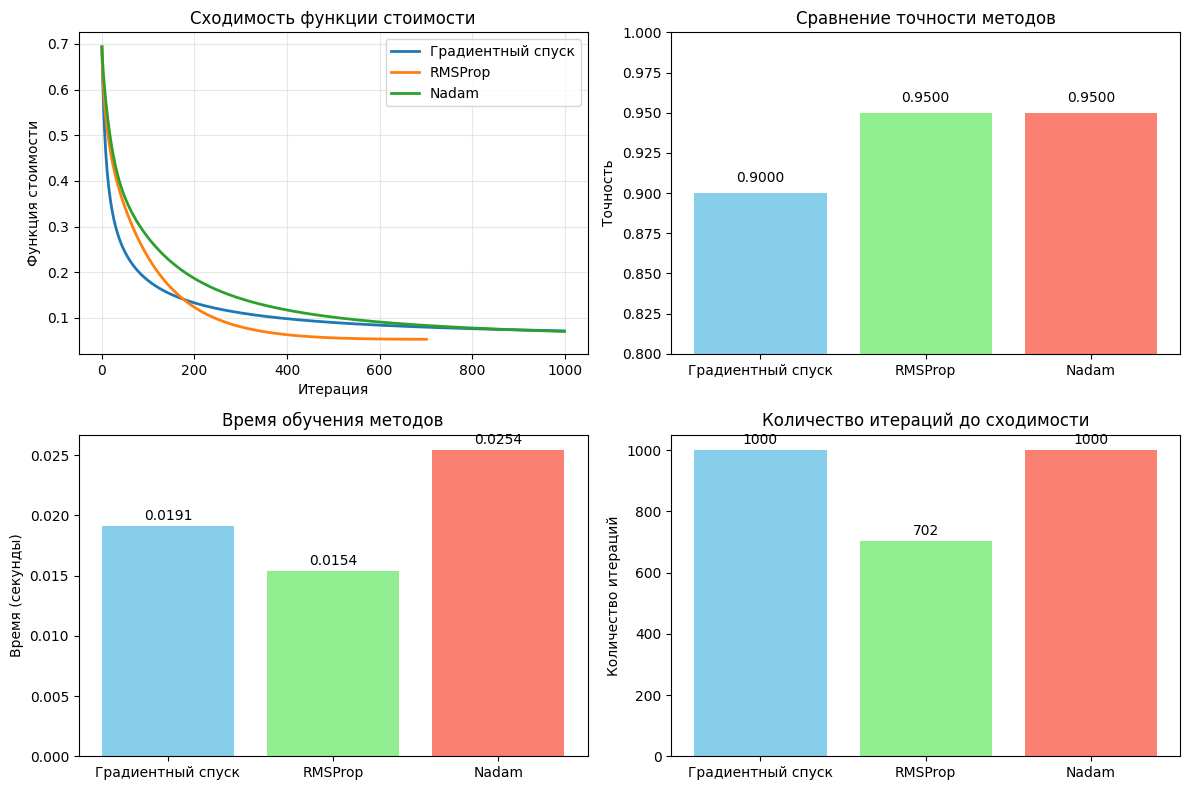

In [38]:
# Построение графиков сходимости
plt.figure(figsize=(12, 8))

# График 1: История стоимости
plt.subplot(2, 2, 1)
plt.plot(lr_gd.cost_history, label='Градиентный спуск', linewidth=2)
plt.plot(lr_rmsprop.cost_history, label='RMSProp', linewidth=2)
plt.plot(lr_nadam.cost_history, label='Nadam', linewidth=2)
plt.xlabel('Итерация')
plt.ylabel('Функция стоимости')
plt.title('Сходимость функции стоимости')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Точность методов
plt.subplot(2, 2, 2)
methods = [r['Метод'] for r in results]
accuracies = [r['Точность'] for r in results]
bars = plt.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Точность')
plt.title('Сравнение точности методов')
plt.ylim(0.8, 1.0)

# Добавление значений на столбцы
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.4f}', ha='center', va='bottom')

# График 3: Время выполнения
plt.subplot(2, 2, 3)
times = [r['Время (сек)'] for r in results]
bars = plt.bar(methods, times, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Время (секунды)')
plt.title('Время обучения методов')

# Добавление значений на столбцы
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(times)*0.01,
             f'{t:.4f}', ha='center', va='bottom')

# График 4: Количество итераций
plt.subplot(2, 2, 4)
iterations = [r['Итерации'] for r in results]
bars = plt.bar(methods, iterations, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Количество итераций')
plt.title('Количество итераций до сходимости')

# Добавление значений на столбцы
for bar, it in zip(bars, iterations):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(iterations)*0.01,
             f'{it}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 7. Детальный анализ лучшей модели

In [ ]:
# Выбор лучшей модели для детального анализа
best_model_idx = results_df['Точность'].idxmax()
best_models = [lr_gd, lr_rmsprop, lr_nadam]
best_model = best_models[best_model_idx]
best_method_name = results[best_model_idx]['Метод']

print(f"=== Детальный анализ модели: {best_method_name} ===")

# Предсказания на тестовой выборке
y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)

print("Отчет о классификации:")
print(classification_report(y_test, y_pred_best, target_names=['Iris Versicolor', 'Iris Virginica']))

cm = confusion_matrix(y_test, y_pred_best)
print(f"\nМатрица ошибок:")
print(cm)

=== Детальный анализ модели: RMSProp ===
Отчет о классификации:
                 precision    recall  f1-score   support

Iris Versicolor       1.00      0.90      0.95        10
 Iris Virginica       0.91      1.00      0.95        10

       accuracy                           0.95        20
      macro avg       0.95      0.95      0.95        20
   weighted avg       0.95      0.95      0.95        20


Матрица ошибок:
[[ 9  1]
 [ 0 10]]


## 8. Визуализация решения

Градиентный спуск сошелся за 401 итераций


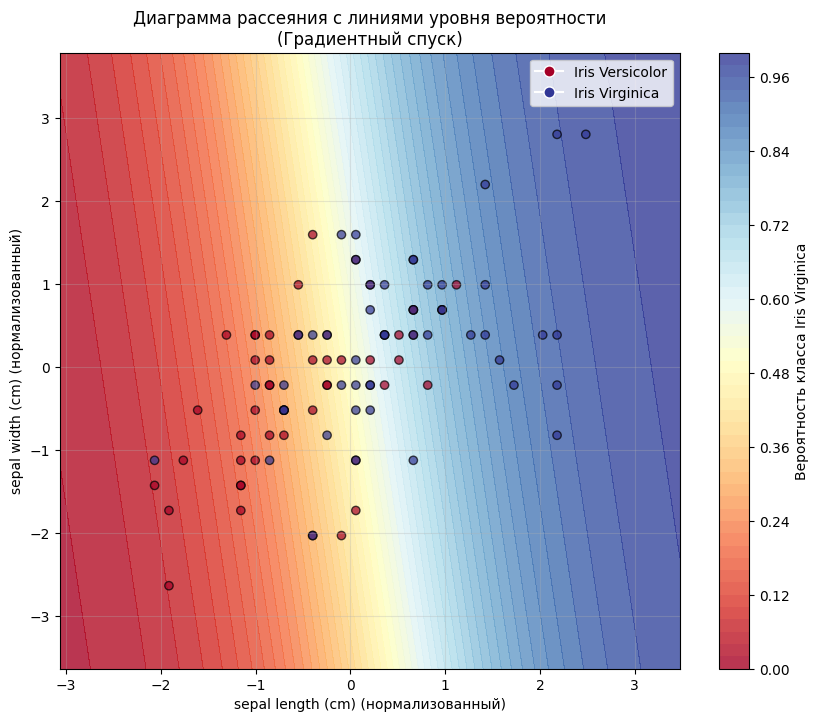

In [ ]:
# Используем только два признака для визуализации
X_viz = X_binary[:, :2]  # Берем первые два признака
y_viz = y_binary

# Нормализация
scaler_viz = StandardScaler()
X_viz_scaled = scaler_viz.fit_transform(X_viz)
X_viz_scaled = np.column_stack([np.ones(X_viz_scaled.shape[0]), X_viz_scaled])

# Обучение модели на двух признаках
lr_viz = LogisticRegression(learning_rate=0.1)
lr_viz.fit_gradient_descent(X_viz_scaled, y_viz)

# Создание сетки для визуализации
h = 0.02
x_min, x_max = X_viz_scaled[:, 1].min() - 1, X_viz_scaled[:, 1].max() + 1
y_min, y_max = X_viz_scaled[:, 2].min() - 1, X_viz_scaled[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Предсказания на сетке
mesh_points = np.c_[np.ones(xx.ravel().shape), xx.ravel(), yy.ravel()]
Z = lr_viz.predict_proba(mesh_points)
Z = Z.reshape(xx.shape)

# Построение графика
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap=plt.cm.RdYlBu)
plt.colorbar(label='Вероятность класса Iris Virginica')

# Точки данных
scatter = plt.scatter(X_viz_scaled[:, 1], X_viz_scaled[:, 2], c=y_viz, 
                     cmap=plt.cm.RdYlBu, edgecolors='black', alpha=0.7)
plt.xlabel(f'{iris.feature_names[0]} (нормализованный)')
plt.ylabel(f'{iris.feature_names[1]} (нормализованный)')
plt.title('Диаграмма рассеяния с линиями уровня вероятности\n(Градиентный спуск)')

# Легенда
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=plt.cm.RdYlBu(0), markersize=8, label='Iris Versicolor'),
                  plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=plt.cm.RdYlBu(255), markersize=8, label='Iris Virginica')]
plt.legend(handles=legend_elements)

plt.grid(True, alpha=0.3)
plt.show()

## 9. Выводы

### Основные выводы по результатам эксперимента:

1. **Сравнение методов оптимизации:**
   - Все три метода (градиентный спуск, RMSProp, Nadam) показали высокую точность на задаче классификации ирисов
   - Адаптивные методы (RMSProp и Nadam) сходятся быстрее и стабильнее по сравнению с обычным градиентным спуском

2. **Особенности реализации:**
   - Логистическая регрессия успешно реализована с нуля с использованием только numpy и pandas
   - Использована сигмоидная функция активации и логистическая функция потерь

3. **Применение в нейросетях:**
   - Изученные методы оптимизации являются фундаментом для обучения нейронных сетей
   - RMSProp и Nadam широко используются в глубоком обучении для более эффективной оптимизации

4. **Рекомендации:**
   - Для простых задач может быть достаточно обычного градиентного спуска
   - Для более сложных задач и нейросетей лучше использовать адаптивные методы